<a href="https://colab.research.google.com/github/rumijay/Data-Science-2025/blob/main/Rumi_Jawad_Unit6Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/eemaansheikh/Data_Science_2025/blob/main/EemaanSheikh_Unit6Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Unit 6 Project

Topic: College admission

What I'm modeling: whether an applicant is admitted (admit = 1) or not (admit = 0).


Variables (potential predictors)

- gpa (0–4)
- sat (800–1600)
- essay (1–10 rubric score)
- ec_hours (0–20 hrs/week)
- major (STEM / Business / Humanities / Arts)
- school_type (Public / Private / Charter)

Outcome: admit (Bernoulli / logistic regression)





```

```

Context

This is NOT me saying this is the one “true” DAG — it’s just my best guess for what causes what.

- Academics (gpa, sat) should directly affect admit
- “Holistic” stuff (essay, ec_hours) should also directly affect admit
- major can change how much certain things matter (ex: essays might matter more in Humanities than STEM)
- school_type might effect preparation/resources, which can indirectly show up in GPA/SAT/essay

So I’m expecting:
- main effects from the predictors
- possibly an interaction between GPA and SAT (they kind of “work together” as academic strength)
- potentially*hierarchical affects by major (becaus e different majors can weight things differently)

---

In [ ]:
!pip -q install bambi

In [2]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import graphviz as gv
import matplotlib.pyplot as plt
import seaborn as sns
import bambi as bmb

In [3]:

rng = np.random.default_rng(6)

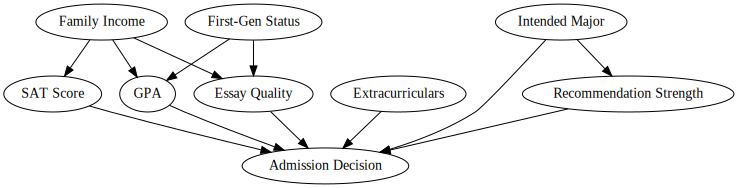

In [35]:
import graphviz as gv

b_dag = gv.Digraph(name="College Admissions")

b_dag.node('G', 'GPA')
b_dag.node('S', 'SAT Score')
b_dag.node('E', 'Essay Quality')
b_dag.node('A', 'Extracurriculars')
b_dag.node('I', 'Family Income')
b_dag.node('F', 'First-Gen Status')
b_dag.node('M', 'Intended Major')
b_dag.node('R', 'Recommendation Strength')
b_dag.node('D', 'Admission Decision')

b_dag.edges([
    'GD','SD','ED','AD','RD','MD',
    'IG','IS','IE',
    'FG','FE',
    'MR'
])

b_dag


In [17]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1ee0CkXhsWbWUKPhSwskXH29uT4vn3hIadwrbDZ1R3Y4/edit#gid=0


In [21]:
df['admit'].mean()

np.float64(0.46714285714285714)

EDa: pairplot + quick checks

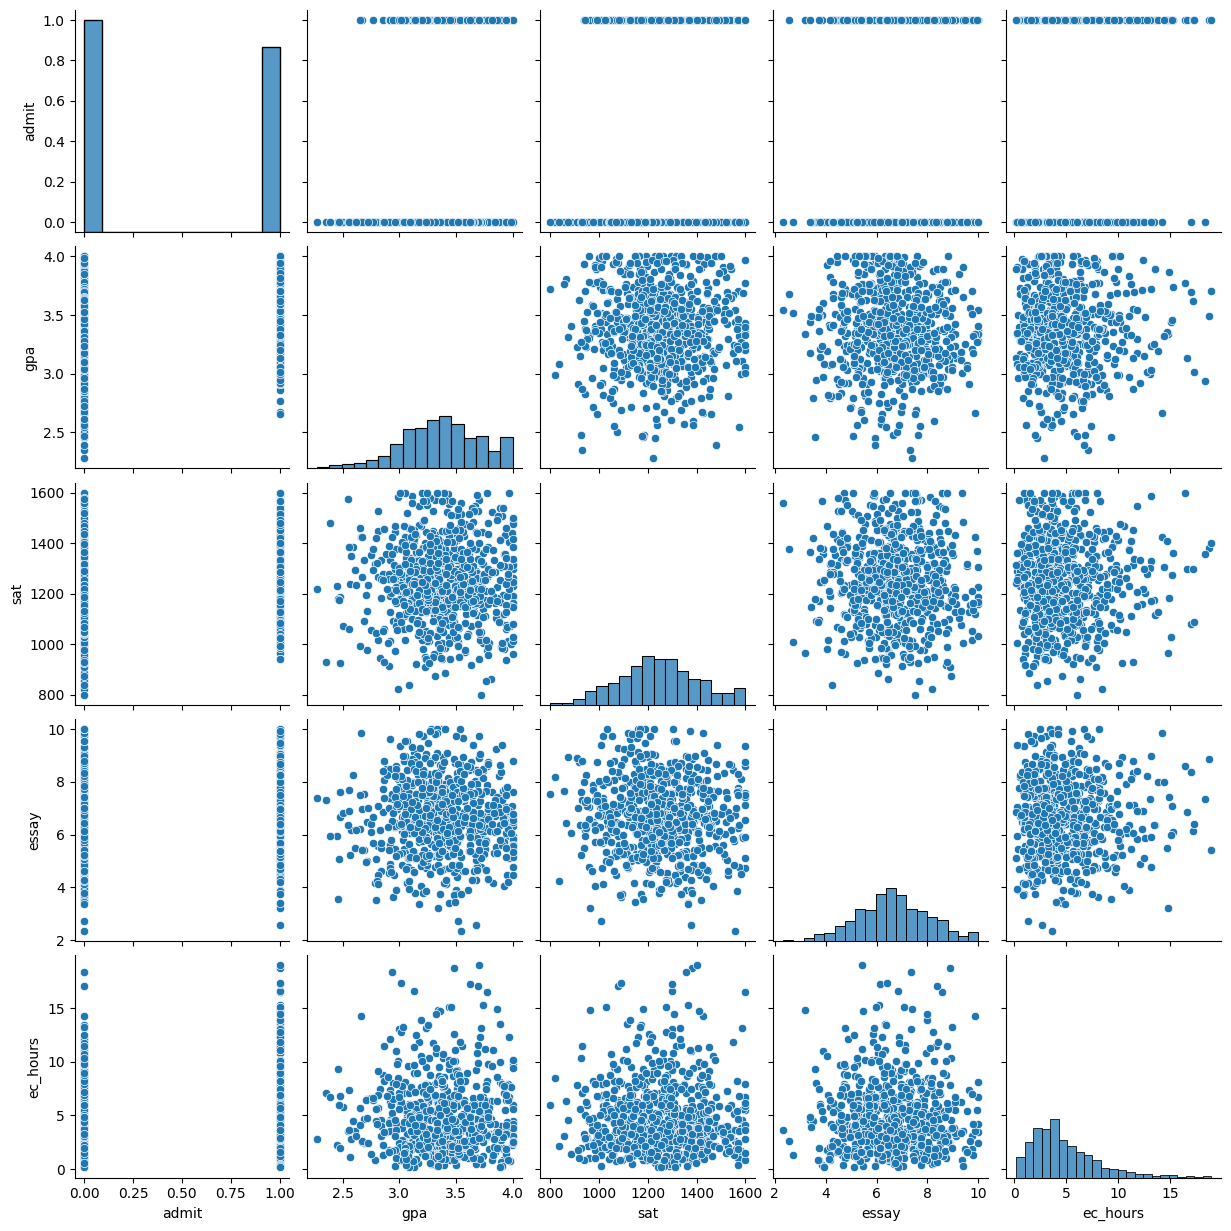

In [19]:
sns.pairplot(df[["admit","gpa","sat","essay","ec_hours"]])
plt.show()

In [7]:
# look at admit rate by major
df.groupby("major")["admit"].mean().sort_values(ascending=False)

,admit
major,
Arts,0.540230
STEM,0.482353
Humanities,0.457317
Business,0.422680


In [ ]:
# look at admit rate by school type
df.groupby("school_type")["admit"].mean().sort_values(ascending=False)

 Modeling

Im going to fit three logistic regression models

1. Main effects model: admit ~ gpa + sat + essay + ec_hours (+ major, school_type)
2. Hierarchical model: let the essay effect vary by major (because I think different majors care differently)
3. Interaction model: add GPA×SAT interaction (academic “combo” effect)





## Model 1: Main effects logistic model

In [8]:
model_main = bmb.Model(
    "admit ~ gpa_z + sat_z + essay_z + ec_hours_z + major + school_type",
    df,
    family="bernoulli"
)
model_main
#used gemini

       Formula: admit ~ gpa_z + sat_z + essay_z + ec_hours_z + major + school_type
        Family: bernoulli
          Link: p = logit
  Observations: 700
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.5)
            gpa_z ~ Normal(mu: 0.0, sigma: 1.0007)
            sat_z ~ Normal(mu: 0.0, sigma: 1.0007)
            essay_z ~ Normal(mu: 0.0, sigma: 1.0007)
            ec_hours_z ~ Normal(mu: 0.0, sigma: 1.0007)
            major ~ Normal(mu: [0. 0. 0.], sigma: [1. 1. 1.])
            school_type ~ Normal(mu: [0. 0.], sigma: [1. 1.])

In [ ]:
idata_main = model_main.fit(idata_kwargs={"log_likelihood": True})
az.summary(idata_main, var_names=["gpa_z","sat_z","essay_z","ec_hours_z"])

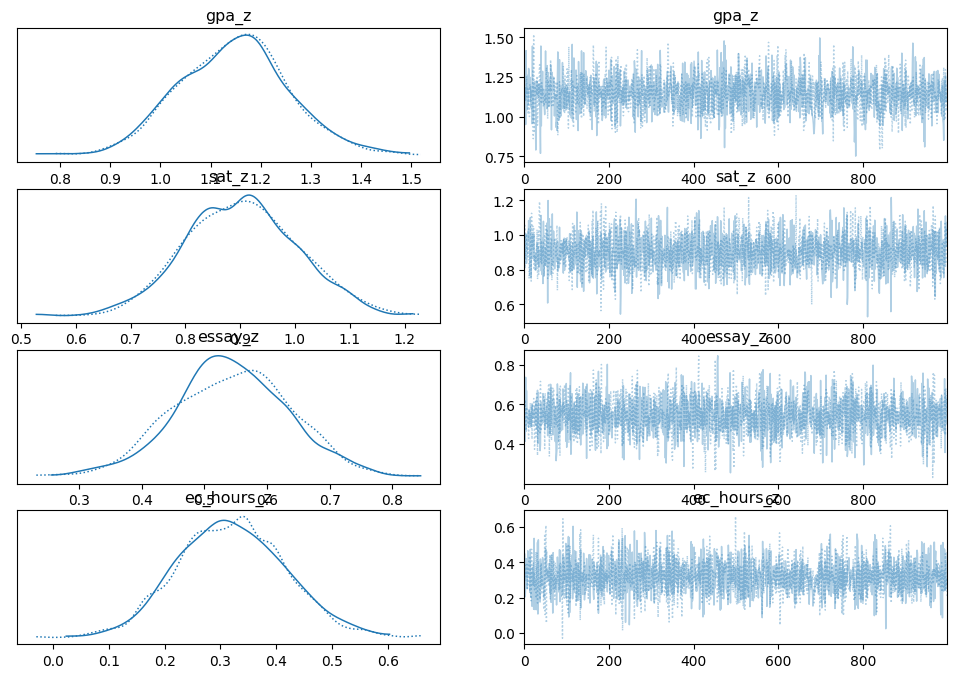

In [10]:
az.plot_trace(idata_main, var_names=["gpa_z","sat_z","essay_z","ec_hours_z"])
plt.show()

## Model 2: Hierarchical (varying essay effect by major)

In [ ]:
model_hier = bmb.Model(
    "admit ~ gpa_z + sat_z + ec_hours_z + school_type + (essay_z|major)",
    df,
    family="bernoulli"
)
model_hier

In [ ]:
idata_hier = model_hier.fit(idata_kwargs={"log_likelihood": True})
az.summary(idata_hier, var_names=["gpa_z","sat_z","ec_hours_z"])

## Model 3: Interaction (GPA × SAT)

In [ ]:
model_inter = bmb.Model(
    "admit ~ gpa_z + sat_z + essay_z + ec_hours_z + major + school_type + gpa_z:sat_z",
    df,
    family="bernoulli"
)
model_inter

In [ ]:
idata_inter = model_inter.fit(idata_kwargs={"log_likelihood": True})
az.summary(idata_inter, var_names=["gpa_z","sat_z","gpa_z:sat_z","essay_z","ec_hours_z"])

Model comparison (LOO)

LOO is basically asking:which model predicts new/unseen data best, while penalizing complexity?

Lower (better) expected out-of-sample deviance is what we want.

---

In [ ]:
cmp_df = az.compare(
    {
        "main_effects": idata_main,
        "hier_by_major": idata_hier,
        "interaction": idata_inter,
    }
)
cmp_df

In [ ]:
az.plot_compare(cmp_df)
plt.show()

---
Posterior predictive / interpretation plots

I’m using bmb.interpret.plot_predictions because it makes the “so what does the model think happens?” part way easier to see.

---

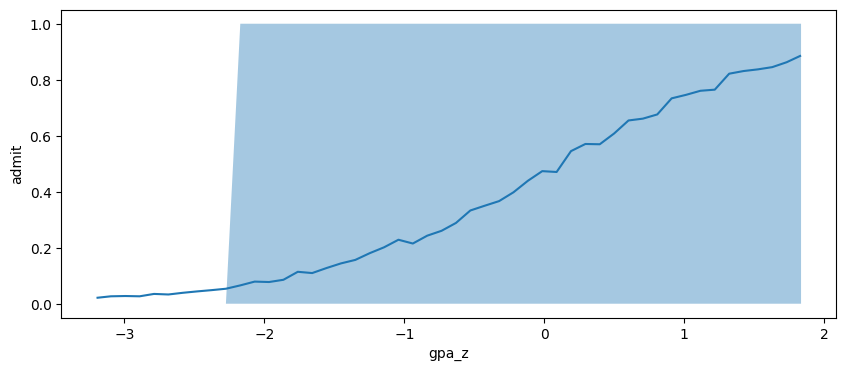

In [24]:
# Predict admission probability as GPA changes (holding others at typical values)
bmb.interpret.plot_predictions(
    model_inter,
    idata_inter,
    ["gpa_z"],
    pps=True,
    fig_kwargs={"figsize": (10, 4)}
)
plt.show()

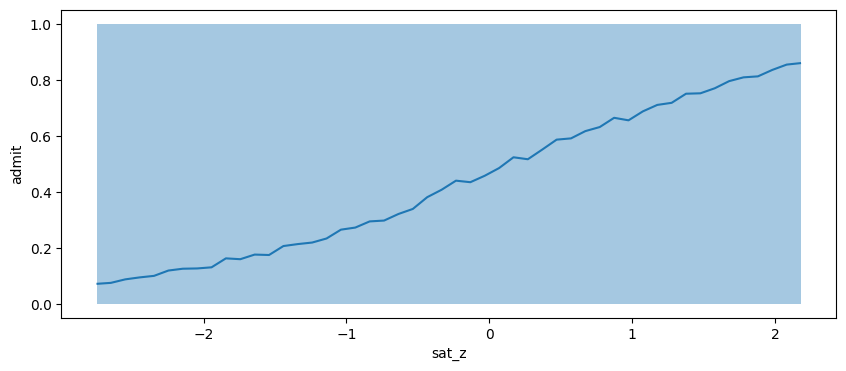

In [26]:
# SAT effect plot
bmb.interpret.plot_predictions(
    model_inter,
    idata_inter,
    ["sat_z"],
    pps=True,
    fig_kwargs={"figsize": (10, 4)}
)
plt.show()

In [ ]:

##sat_levels = [-1.0, 0.0, 1.0]

fig = plt.figure(figsize=(10,4))
for s in sat_levels:
    grid = pd.DataFrame({
        "gpa_z": np.linspace(-2.2, 2.2, 60),
        "sat_z": s,
        "essay_z": 0.0,
        "ec_hours_z": 0.0,
        "major": "STEM",
        "school_type": "Public",
    })
   ## preds = model_inter.predict(idata_inter, data=grid, kind="response_params").to_numpy()
  ##  plt.plot(grid["gpa_z"], preds, label=f"sat_z = {s}")

plt.show()

Conclusion

- **Model 1 (main effects)** is the clean baseline: it answers “what matters, on average?”
- **Model 2 (hierarchical)** is me being realistic: different majors might value essays differently, so I let thhat slope vary.
- **Model 3 (interaction)** tests the idea that GPA and SAT together can be more informative than either alone.

**What I’d actually use:** whichever model wins the comparison. If the interaction model wins, tha t supports the “academic combo” idea.  
If the hierarchical model wins, that supports the idea that different majors really do weigh essays differently.

Either way, the big takeaway is: multiple predictors + model comparison is way more convincing than just throwing one variable at the wall and hoping it explains everything.
